In [1]:
import time
start_time = time.time()

# Preparation - Data grouped on forum level

Import the packages and load the data

In [2]:
# Import needed READkages
import os
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import KBinsDiscretizer
import seaborn as sns; sns.set()
import glob
from sklearn.linear_model import LinearRegression
from statsmodels.formula.api import ols
import re
import nltk
from langdetect import detect
from sklearn import feature_extraction, model_selection, naive_bayes, pipeline, manifold, preprocessing
from lime import lime_text
import gensim
import gensim.downloader as gensim_api
from tensorflow.keras import models, layers, preprocessing as kprocessing
from tensorflow.keras import backend as K
import transformers
plt.style.use('seaborn-whitegrid')
sns.set_style("whitegrid")
from bs4 import BeautifulSoup
from tqdm import tqdm
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.snowball import EnglishStemmer
import spacy
from spacy import displacy
from wordcloud import WordCloud
from sklearn.preprocessing import KBinsDiscretizer
from nbpep8.nbpep8 import pep8
from sklearn.metrics.pairwise import cosine_similarity
from linearmodels import PanelOLS
from linearmodels.panel import PanelOLS
from linearmodels.panel import PooledOLS
import statsmodels.api as sm
from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan
from sklearn.preprocessing import MinMaxScaler

In [3]:
#Set the working directory
os.chdir('C:\\Users\\piotr\\OneDrive - Erasmus University Rotterdam\\Thesis\\')

In [4]:
#Load the results of the content novelty calculation, that were saved as follows:
final_result_df_tfidf = pd.read_csv('Master Thesis Data\\final_result_df_tfidf.csv')
final_result_df_lsi = pd.read_csv('Master Thesis Data\\final_result_df_lsi.csv')
final_result_df_doc2vec = pd.read_csv('Master Thesis Data\\final_result_df_doc2vec.csv')

Load the grouped data frames

In [5]:
#Load the estimation data frames
est_grouped_df_week = pd.read_csv('Master Thesis Data\\estimation_dfs\\est_grouped_df_week.csv')
est_grouped_df_week_tag = pd.read_csv('Master Thesis Data\\estimation_dfs\\est_grouped_df_week_tag.csv')
est_grouped_df_week_tag_reduced = pd.read_csv('Master Thesis Data\\estimation_dfs\\est_grouped_df_week_tag_reduced.csv')

Drop the weeks (Week_of_Year) 17 and 26 from all dfs

In [6]:
##Drop the weeks (Week_of_Year) 17 and 26 from all dfs, as they are incomplete
est_grouped_df_week = est_grouped_df_week[est_grouped_df_week['Week_of_Year'] != 17]
est_grouped_df_week = est_grouped_df_week[est_grouped_df_week['Week_of_Year'] != 26]
est_grouped_df_week_tag = est_grouped_df_week_tag[est_grouped_df_week_tag['Week_of_Year'] != 17]
est_grouped_df_week_tag = est_grouped_df_week_tag[est_grouped_df_week_tag['Week_of_Year'] != 26]
est_grouped_df_week_tag_reduced = est_grouped_df_week_tag_reduced[est_grouped_df_week_tag_reduced['Week_of_Year'] != 17]
est_grouped_df_week_tag_reduced = est_grouped_df_week_tag_reduced[est_grouped_df_week_tag_reduced['Week_of_Year'] != 26]

In [8]:
est_grouped_df_week.head(5)

,Forum,Post_Creation_Date,Post_Count,Post_Answer_Count,ari,fre,fk_grade,gunning_fog,smog_index,coleman_liau_index,...,Post_View_Count,Post_Score,Response_Scores,Post_Author,Answer_Author,Title_Length,Body_Length,Week_Start_Date,Week_Number,DiD
1,Android Enthusiasts,2021-07-05/2021-07-11,41,15,8.573171,72.279024,7.529268,9.050244,8.139024,7.314634,...,23487,47,19,35,5,62.609756,888.195122,2021-07-05,2,0
2,Android Enthusiasts,2021-07-12/2021-07-18,35,22,8.145714,71.622857,7.251429,8.704857,8.442857,7.614286,...,18009,24,30,34,8,58.142857,946.485714,2021-07-12,3,0
3,Android Enthusiasts,2021-07-19/2021-07-25,47,25,10.914894,65.040000,9.553191,11.086809,8.517021,8.035745,...,38060,51,21,39,7,58.468085,1016.382979,2021-07-19,4,0
4,Android Enthusiasts,2021-07-26/2021-08-01,35,19,8.882857,72.276286,7.891429,9.674857,8.637143,7.178000,...,23630,31,13,32,4,70.000000,888.857143,2021-07-26,5,0
5,Android Enthusiasts,2021-08-02/2021-08-08,43,11,9.306977,69.547907,8.220930,9.906279,8.416279,7.630233,...,13408,35,13,40,5,63.418605,1140.069767,2021-08-02,6,0


## Average the readability metrics

Columns with different redability metrics:

ari	

fre	 (1-fre)

fk_grade

gunning_fog

smog_index	

coleman_liau_index

In [9]:
# Instantiate the scaler
scaler = MinMaxScaler()

# List of columns to normalize
cols_to_normalize = ['ari', 'fre', 'fk_grade', 'gunning_fog', 'smog_index', 'coleman_liau_index']

# List of DataFrames
dfs = [est_grouped_df_week, est_grouped_df_week_tag, est_grouped_df_week_tag_reduced]

# Apply normalization and averaging to each DataFrame
for df in dfs:
    # Apply the scaler to the DataFrame
    df[cols_to_normalize] = scaler.fit_transform(df[cols_to_normalize])

    # Invert the 'fre' column
    df['fre'] = 1 - df['fre']

    # Add a new column with the average of the normalized columns
    df['avg_readability'] = df[cols_to_normalize].mean(axis=1)


# Choose the data frame

Note that the data ranges from 01-07-2021 to 30-04-2022 and from 01-07-2022 to 30-04-2023. That implies that the weeks 18,19,20,21,22,23,24,25 are not present in the data set.
Weeks 17 and 26 are dropped as they are incomplete

# 8.1 PTA - tag reduced level

## 8.1.1 Post Counts

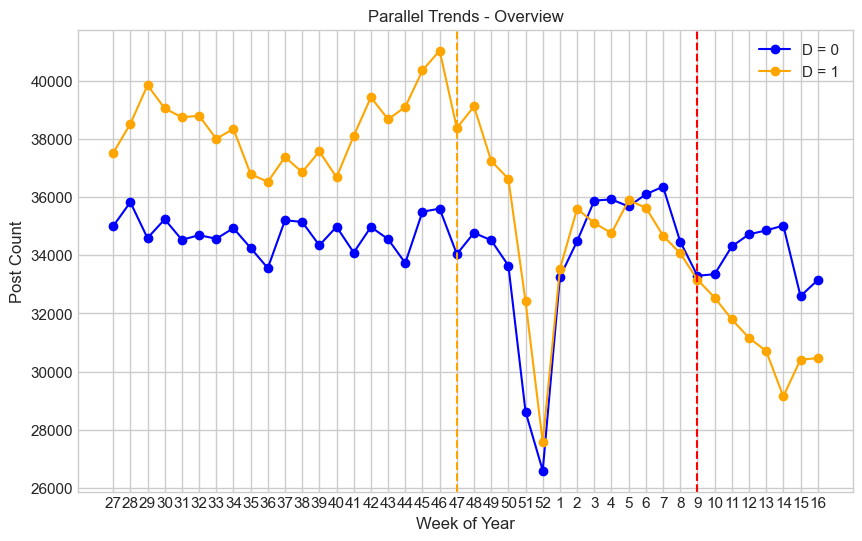

In [12]:
df = est_grouped_df_week.copy()

# Create separate dataframes for D=0 and D=1
df_D0 = df[df['D'] == 0]
df_D1 = df[df['D'] == 1]

# Group by 'Week_of_Year' and calculate the sum 'Post_Count'
df_D0_grouped = df_D0.groupby('Week_of_Year')['Post_Count'].sum()
df_D1_grouped = df_D1.groupby('Week_of_Year')['Post_Count'].sum()

# Separate the weeks into two halves
first_half_D0 = df_D0_grouped[df_D0_grouped.index >= 27]
second_half_D0 = df_D0_grouped[df_D0_grouped.index < 27]
df_D0_grouped = pd.concat([first_half_D0, second_half_D0])

first_half_D1 = df_D1_grouped[df_D1_grouped.index >= 27]
second_half_D1 = df_D1_grouped[df_D1_grouped.index < 27]
df_D1_grouped = pd.concat([first_half_D1, second_half_D1])

# Create a new sequence of numbers for x-axis representing the actual order of weeks.
new_x = np.arange(1, len(df_D0_grouped) + 1)

# Plot the post counts for each group as lines with points
plt.figure(figsize=(10, 6))
plt.plot(new_x, df_D0_grouped.values, marker='o', color='blue', label='D = 0')
plt.plot(new_x, df_D1_grouped.values, marker='o', color='orange', label='D = 1')

# Add legend
plt.legend()

plt.title("Parallel Trends - Overview")
plt.xlabel("Week of Year")
plt.ylabel("Post Count")
plt.grid(True)


# Add dashed orange line for week 49
plt.axvline(21, color='orange', linestyle='--')

# Add dashed red line for week 11
plt.axvline(35, color='red', linestyle='--')

# Show actual weeks on x-axis
plt.xticks(ticks=new_x, labels=df_D0_grouped.index)

plt.show()


In [13]:
#Drop Week_Number
df = df.drop(['Week_Number'], axis=1)


# Generate the dummy variables for the periods
for i in range(1, 53):
    if i != 0 and i != 48:  # Exclude Week_of_Year 48 (dummy trap)
        df[f'Week_of_Year_{i}'] = np.where(df['Week_of_Year'] == i, 1, 0)
        df[f'Week_of_Year_{i}_D'] = df[f'Week_of_Year_{i}'] * df['D']


# Set the index for the panel data
df = df.set_index(['Forum', 'Week_of_Year'])

# Create exogenous variables and add a constant
# Create exogenous variables and add a constant
exog_vars = [f'Week_of_Year_{i}_D' for i in range(1, 53) if i != 0 and i != 48]  # Exclude Week_of_Year == 48 (dummy trap)
exog = sm.add_constant(df[exog_vars])


# Run the regression
mod = PanelOLS(df.Post_Count, exog, entity_effects=True, check_rank=False, drop_absorbed=True, time_effects=True)
fe_res = mod.fit(cov_type='clustered', cluster_entity=True)



# Print the result
print(fe_res)

C:\Users\piotr\AppData\Local\Temp\ipykernel_15300\1121484556.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'Week_of_Year_{i}_D'] = df[f'Week_of_Year_{i}'] * df['D']
C:\Users\piotr\AppData\Local\Temp\ipykernel_15300\1121484556.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'Week_of_Year_{i}'] = np.where(df['Week_of_Year'] == i, 1, 0)
C:\Users\piotr\AppData\Local\Temp\ipykernel_15300\1121484556.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many ti

                          PanelOLS Estimation Summary                           
Dep. Variable:             Post_Count   R-squared:                        0.0130
Estimator:                   PanelOLS   R-squared (Between):           -2.22e-16
No. Observations:                2940   R-squared (Within):               0.0213
Date:                Mon, May 22 2023   R-squared (Overall):              0.0002
Time:                        13:24:08   Log-likelihood                -2.176e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      0.9038
Entities:                          35   P-value                           0.6461
Avg Obs:                       84.000   Distribution:                 F(41,2823)
Min Obs:                       84.000                                           
Max Obs:                       84.000   F-statistic (robust):           -3.1e+12
                            

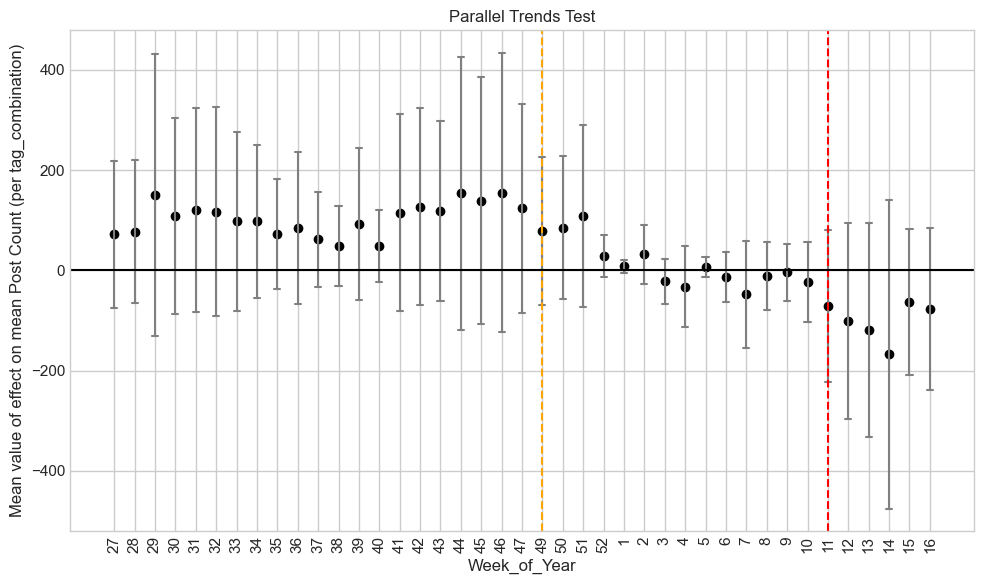

In [14]:
# Extract parameters and t-statistics from fe_res
params = fe_res.params[1:]  # Exclude constant
tvalues = fe_res.tstats[1:]  # Exclude constant

# Calculate standard errors: sqrt of variance
stderr = np.sqrt(np.diag(fe_res.cov))[1:]  # Exclude constant

# Calculate p-values
pvalues = fe_res.pvalues[1:]  # Exclude constant

# Create a new DataFrame from these values
results_df = pd.DataFrame({"params": params, "stderr": stderr, "tvalues": tvalues, "pvalues": pvalues})

# Add 'Week_of_Year' values as a column
# As per your input, these range from 1 to 16 and 27 to 47, 49 to 52
week_of_year_values = list(range(1, 17)) + list(range(27, 48)) + list(range(49, 53))
results_df["Week_of_Year"] = week_of_year_values

# Calculate lower and upper CI (assuming normal distribution)
results_df["lower_ci"] = results_df["params"] - 1.96*results_df["stderr"]
results_df["upper_ci"] = results_df["params"] + 1.96*results_df["stderr"]

# Create a custom order for 'Week_of_Year' - from 27 to 52, and then from 1 to 16
order = list(range(27, 48)) + list(range(49, 53)) + list(range(1, 17))

# Create a mapping of week numbers to new ordered indices
week_to_idx = {week: idx for idx, week in enumerate(order)}

# Map 'Week_of_Year' to the new ordered indices
results_df['Week_of_Year_Idx'] = results_df['Week_of_Year'].map(week_to_idx)

# Sort by the new index
results_df.sort_values("Week_of_Year_Idx", inplace=True)

# Create the plot
plt.figure(figsize=(10, 6))

# Plot the parameters as black scatter points
plt.scatter(results_df['Week_of_Year_Idx'], results_df['params'], color='black')

# Add vertical 'boxes' for each 'Week_of_Year'
for _, row in results_df.iterrows():
    plt.plot([row['Week_of_Year_Idx'], row['Week_of_Year_Idx']], [row['lower_ci'], row['upper_ci']], color="gray")

# Add short orthogonal lines at the top and bottom of each box
box_width = 0.3  # Adjust as needed
for _, row in results_df.iterrows():
    plt.plot([row['Week_of_Year_Idx'] - box_width/2, row['Week_of_Year_Idx'] + box_width/2], [row['lower_ci'], row['lower_ci']], color="gray")
    plt.plot([row['Week_of_Year_Idx'] - box_width/2, row['Week_of_Year_Idx'] + box_width/2], [row['upper_ci'], row['upper_ci']], color="gray")


# Add dashed orange line for week 49
plt.axvline(21, color='orange', linestyle='--')

# Add dashed red line for week 11
plt.axvline(35, color='red', linestyle='--')

# Add firm blue line for value 0 on y-axis
plt.axhline(0, color='black', linestyle='-')



# Adjust x-axis to display actual week numbers
plt.xticks(results_df['Week_of_Year_Idx'], results_df['Week_of_Year'], rotation='vertical')

plt.title("Parallel Trends Test")
plt.xlabel("Week_of_Year")
plt.ylabel("Mean value of effect on mean Post Count (per tag_combination)")

plt.tight_layout()
plt.show()


## 8.1.2 Post_Answer_Count

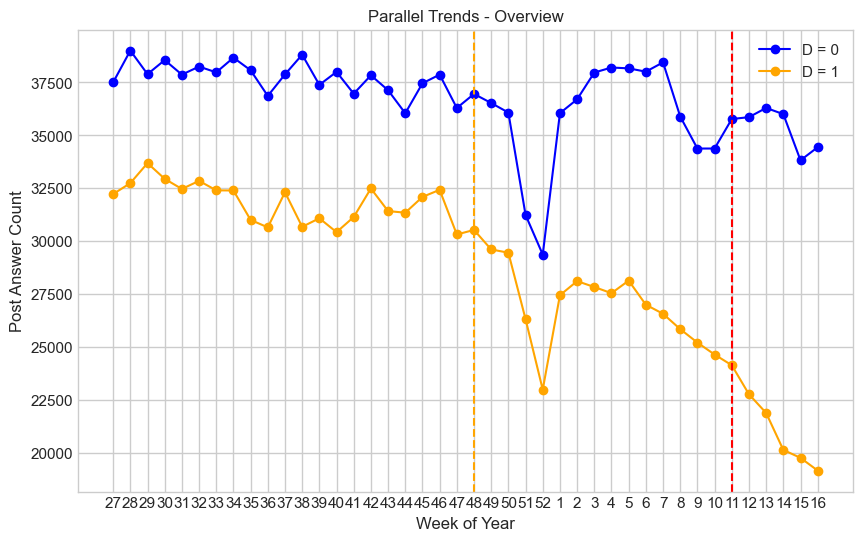

In [15]:
df = est_grouped_df_week.copy()

# Create separate dataframes for D=0 and D=1
df_D0_PAC = df[df['D'] == 0]
df_D1_PAC = df[df['D'] == 1]

# Group by 'Week_of_Year' and calculate the sum 'Post_Count'
df_D0_grouped_PAC = df_D0_PAC.groupby('Week_of_Year')['Post_Answer_Count'].sum()
df_D1_grouped_PAC = df_D1_PAC.groupby('Week_of_Year')['Post_Answer_Count'].sum()

# Separate the weeks into two halves
first_half_D0_PAC = df_D0_grouped_PAC[df_D0_grouped_PAC.index >= 27]
second_half_D0_PAC = df_D0_grouped_PAC[df_D0_grouped_PAC.index < 27]
df_D0_grouped_PAC = pd.concat([first_half_D0_PAC, second_half_D0_PAC])

first_half_D1_PAC = df_D1_grouped_PAC[df_D1_grouped_PAC.index >= 27]
second_half_D1_PAC = df_D1_grouped_PAC[df_D1_grouped_PAC.index < 27]
df_D1_grouped_PAC = pd.concat([first_half_D1_PAC, second_half_D1_PAC])

# Create a new sequence of numbers for x-axis representing the actual order of weeks.
new_x = np.arange(1, len(df_D0_grouped_PAC) + 1)

# Plot the post counts for each group as lines with points
plt.figure(figsize=(10, 6))
plt.plot(new_x, df_D0_grouped_PAC.values, marker='o', color='blue', label='D = 0')
plt.plot(new_x, df_D1_grouped_PAC.values, marker='o', color='orange', label='D = 1')

# Add legend
plt.legend()

plt.title("Parallel Trends - Overview")
plt.xlabel("Week of Year")
plt.ylabel("Post Answer Count")
plt.grid(True)


# Add dashed orange line for week 49
plt.axvline(22, color='orange', linestyle='--')

# Add dashed red line for week 11
plt.axvline(37, color='red', linestyle='--')

# Show actual weeks on x-axis
plt.xticks(ticks=new_x, labels=df_D0_grouped.index)

plt.show()


In [16]:
#Drop Week_Number
df = df.drop(['Week_Number'], axis=1)


# Generate the dummy variables for the periods
for i in range(1, 53):
    if i != 0 and i != 48:  # Exclude Week_of_Year 48 (dummy trap)
        df[f'Week_of_Year_{i}'] = np.where(df['Week_of_Year'] == i, 1, 0)
        df[f'Week_of_Year_{i}_D'] = df[f'Week_of_Year_{i}'] * df['D']


# Set the index for the panel data
df = df.set_index(['Forum', 'Week_of_Year'])

# Create exogenous variables and add a constant
# Create exogenous variables and add a constant
exog_vars = [f'Week_of_Year_{i}_D' for i in range(1, 53) if i != 0 and i != 48]  # Exclude Week_of_Year == 48 (dummy trap)
exog = sm.add_constant(df[exog_vars])


# Run the regression
mod_PAC = PanelOLS(df.Post_Answer_Count, exog, entity_effects=True, check_rank=False, drop_absorbed=True, time_effects=True)
fe_res_PAC = mod_PAC.fit(cov_type='clustered', cluster_entity=True)



# Print the result
print(fe_res_PAC)

C:\Users\piotr\AppData\Local\Temp\ipykernel_15300\3000549981.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'Week_of_Year_{i}_D'] = df[f'Week_of_Year_{i}'] * df['D']
C:\Users\piotr\AppData\Local\Temp\ipykernel_15300\3000549981.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'Week_of_Year_{i}'] = np.where(df['Week_of_Year'] == i, 1, 0)
C:\Users\piotr\AppData\Local\Temp\ipykernel_15300\3000549981.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many ti

                          PanelOLS Estimation Summary                           
Dep. Variable:      Post_Answer_Count   R-squared:                        0.0268
Estimator:                   PanelOLS   R-squared (Between):              0.0000
No. Observations:                2940   R-squared (Within):               0.0314
Date:                Mon, May 22 2023   R-squared (Overall):              0.0009
Time:                        13:25:22   Log-likelihood                 -2.36e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      1.8935
Entities:                          35   P-value                           0.0005
Avg Obs:                       84.000   Distribution:                 F(41,2823)
Min Obs:                       84.000                                           
Max Obs:                       84.000   F-statistic (robust):          6.621e+10
                            

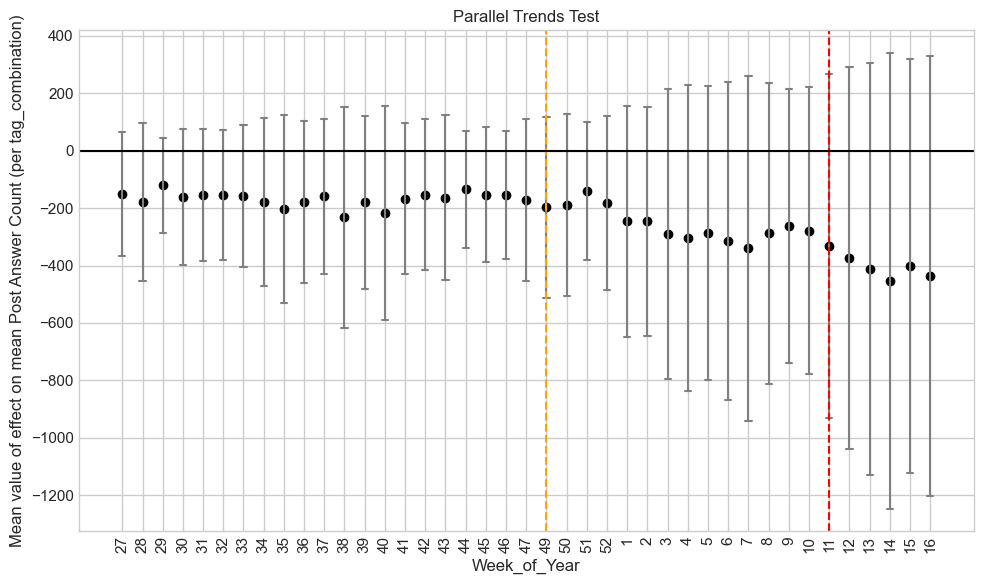

In [17]:
# Extract parameters and t-statistics from fe_res
params_PAC = fe_res_PAC.params[1:]  # Exclude constant
tvalues_PAC = fe_res_PAC.tstats[1:]  # Exclude constant

# Calculate standard errors: sqrt of variance
stderr_PAC = np.sqrt(np.diag(fe_res_PAC.cov))[1:]  # Exclude constant

# Calculate p-values
pvalues_PAC = fe_res_PAC.pvalues[1:]  # Exclude constant

# Create a new DataFrame from these values
results_df_PAC = pd.DataFrame({"params": params_PAC, "stderr": stderr_PAC, "tvalues": tvalues_PAC, "pvalues": pvalues_PAC})

# Add 'Week_of_Year' values as a column
# As per your input, these range from 1 to 16 and 27 to 47, 49 to 52
week_of_year_values = list(range(1, 17)) + list(range(27, 48)) + list(range(49, 53))
results_df_PAC["Week_of_Year"] = week_of_year_values

# Calculate lower and upper CI (assuming normal distribution)
results_df_PAC["lower_ci"] = results_df_PAC["params"] - 1.96*results_df_PAC["stderr"]
results_df_PAC["upper_ci"] = results_df_PAC["params"] + 1.96*results_df_PAC["stderr"]

# Create a custom order for 'Week_of_Year' - from 27 to 52, and then from 1 to 16
order = list(range(27, 48)) + list(range(49, 53)) + list(range(1, 17))

# Create a mapping of week numbers to new ordered indices
week_to_idx = {week: idx for idx, week in enumerate(order)}

# Map 'Week_of_Year' to the new ordered indices
results_df_PAC['Week_of_Year_Idx'] = results_df_PAC['Week_of_Year'].map(week_to_idx)

# Sort by the new index
results_df_PAC.sort_values("Week_of_Year_Idx", inplace=True)

# Create the plot
plt.figure(figsize=(10, 6))

# Plot the parameters as black scatter points
plt.scatter(results_df_PAC['Week_of_Year_Idx'], results_df_PAC['params'], color='black')

# Add vertical 'boxes' for each 'Week_of_Year'
for _, row in results_df_PAC.iterrows():
    plt.plot([row['Week_of_Year_Idx'], row['Week_of_Year_Idx']], [row['lower_ci'], row['upper_ci']], color="gray")

# Add short orthogonal lines at the top and bottom of each box
box_width = 0.3  # Adjust as needed
for _, row in results_df_PAC.iterrows():
    plt.plot([row['Week_of_Year_Idx'] - box_width/2, row['Week_of_Year_Idx'] + box_width/2], [row['lower_ci'], row['lower_ci']], color="gray")
    plt.plot([row['Week_of_Year_Idx'] - box_width/2, row['Week_of_Year_Idx'] + box_width/2], [row['upper_ci'], row['upper_ci']], color="gray")


# Add dashed orange line for week 49
plt.axvline(21, color='orange', linestyle='--')

# Add dashed red line for week 11
plt.axvline(35, color='red', linestyle='--')

# Add firm blue line for value 0 on y-axis
plt.axhline(0, color='black', linestyle='-')



# Adjust x-axis to display actual week numbers
plt.xticks(results_df_PAC['Week_of_Year_Idx'], results_df_PAC['Week_of_Year'], rotation='vertical')

plt.title("Parallel Trends Test")
plt.xlabel("Week_of_Year")
plt.ylabel("Mean value of effect on mean Post Answer Count (per tag_combination)")

plt.tight_layout()
plt.show()


## 8.1.3 Average Readability

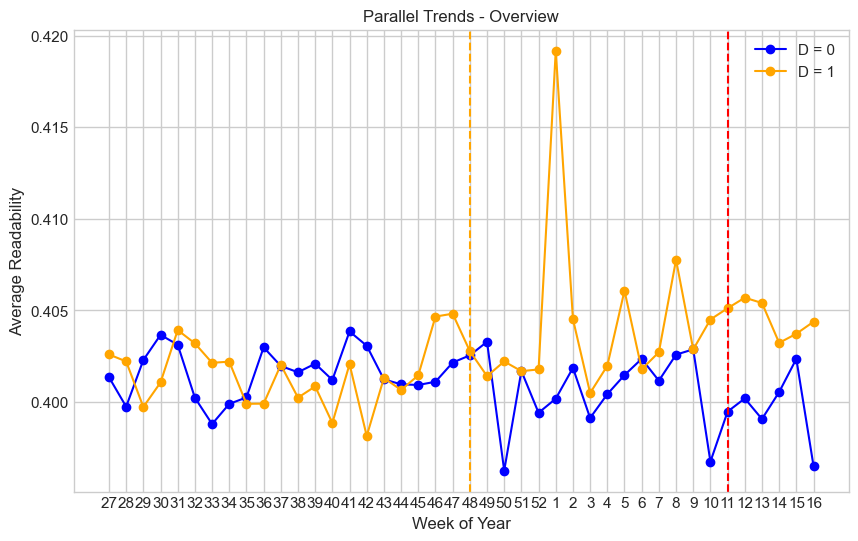

In [19]:
df = est_grouped_df_week.copy()

# Create separate dataframes for D=0 and D=1
df_D0_READ = df[df['D'] == 0]
df_D1_READ = df[df['D'] == 1]

# Group by 'Week_of_Year' and calculate the sum 'Post_Count'
df_D0_grouped_READ = df_D0_READ.groupby('Week_of_Year')['avg_readability'].mean()
df_D1_grouped_READ = df_D1_READ.groupby('Week_of_Year')['avg_readability'].mean()

# Separate the weeks into two halves
first_half_D0_READ = df_D0_grouped_READ[df_D0_grouped_READ.index >= 27]
second_half_D0_READ = df_D0_grouped_READ[df_D0_grouped_READ.index < 27]
df_D0_grouped_READ = pd.concat([first_half_D0_READ, second_half_D0_READ])

first_half_D1_READ = df_D1_grouped_READ[df_D1_grouped_READ.index >= 27]
second_half_D1_READ = df_D1_grouped_READ[df_D1_grouped_READ.index < 27]
df_D1_grouped_READ = pd.concat([first_half_D1_READ, second_half_D1_READ])

# Create a new sequence of numbers for x-axis representing the actual order of weeks.
new_x = np.arange(1, len(df_D0_grouped_READ) + 1)

# Plot the post counts for each group as lines with points
plt.figure(figsize=(10, 6))
plt.plot(new_x, df_D0_grouped_READ.values, marker='o', color='blue', label='D = 0')
plt.plot(new_x, df_D1_grouped_READ.values, marker='o', color='orange', label='D = 1')

# Add legend
plt.legend()

plt.title("Parallel Trends - Overview")
plt.xlabel("Week of Year")
plt.ylabel("Average Readability")
plt.grid(True)


# Add dashed orange line for week 49
plt.axvline(22, color='orange', linestyle='--')

# Add dashed red line for week 11
plt.axvline(37, color='red', linestyle='--')

# Show actual weeks on x-axis
plt.xticks(ticks=new_x, labels=df_D0_grouped.index)

plt.show()


In [20]:
#Drop Week_Number
df = df.drop(['Week_Number'], axis=1)


# Generate the dummy variables for the periods
for i in range(1, 53):
    if i != 0 and i != 48:  # Exclude Week_of_Year 48 (dummy trap)
        df[f'Week_of_Year_{i}'] = np.where(df['Week_of_Year'] == i, 1, 0)
        df[f'Week_of_Year_{i}_D'] = df[f'Week_of_Year_{i}'] * df['D']


# Set the index for the panel data
df = df.set_index(['Forum', 'Week_of_Year'])

# Create exogenous variables and add a constant
# Create exogenous variables and add a constant
exog_vars = [f'Week_of_Year_{i}_D' for i in range(1, 53) if i != 0 and i != 48]  # Exclude Week_of_Year == 48 (dummy trap)
exog = sm.add_constant(df[exog_vars])


# Run the regression
mod_READ = PanelOLS(df.avg_readability, exog, entity_effects=True, check_rank=False, drop_absorbed=True, time_effects=True)
fe_res_READ = mod_READ.fit(cov_type='clustered', cluster_entity=True)



# Print the result
print(fe_res_READ)


C:\Users\piotr\AppData\Local\Temp\ipykernel_15300\4097092152.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'Week_of_Year_{i}_D'] = df[f'Week_of_Year_{i}'] * df['D']
C:\Users\piotr\AppData\Local\Temp\ipykernel_15300\4097092152.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'Week_of_Year_{i}'] = np.where(df['Week_of_Year'] == i, 1, 0)
C:\Users\piotr\AppData\Local\Temp\ipykernel_15300\4097092152.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many ti

                          PanelOLS Estimation Summary                           
Dep. Variable:        avg_readability   R-squared:                        0.0267
Estimator:                   PanelOLS   R-squared (Between):              0.0000
No. Observations:                2940   R-squared (Within):               0.0244
Date:                Mon, May 22 2023   R-squared (Overall):              0.0003
Time:                        13:26:33   Log-likelihood                    8529.5
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      1.8892
Entities:                          35   P-value                           0.0006
Avg Obs:                       84.000   Distribution:                 F(41,2823)
Min Obs:                       84.000                                           
Max Obs:                       84.000   F-statistic (robust):          9.485e+15
                            

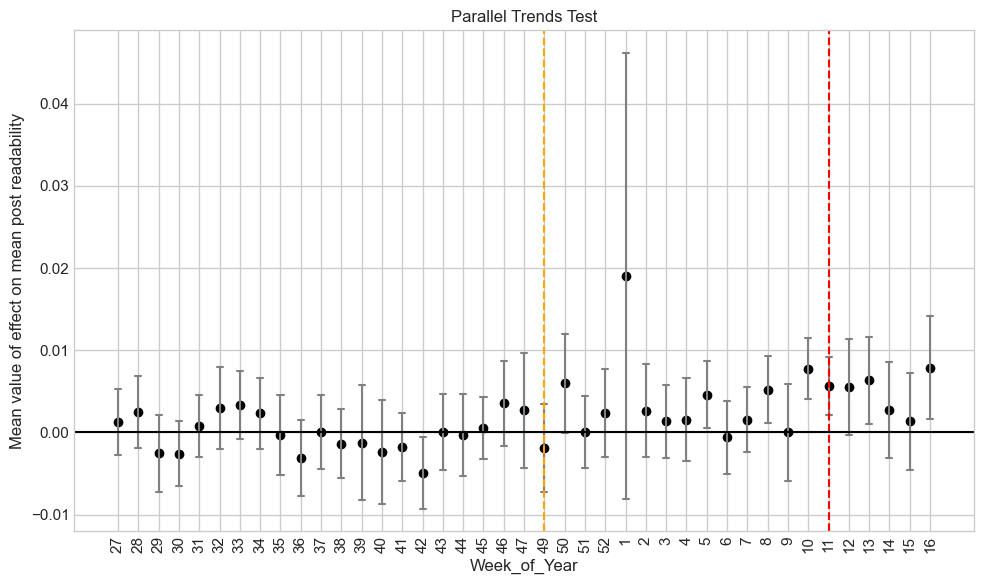

In [21]:
# Extract parameters and t-statistics from fe_res
params_READ = fe_res_READ.params[1:]  # Exclude constant
tvalues_READ = fe_res_READ.tstats[1:]  # Exclude constant

# Calculate standard errors: sqrt of variance
stderr_READ = np.sqrt(np.diag(fe_res_READ.cov))[1:]  # Exclude constant

# Calculate p-values
pvalues_READ = fe_res_READ.pvalues[1:]  # Exclude constant

# Create a new DataFrame from these values
results_df_READ = pd.DataFrame({"params": params_READ, "stderr": stderr_READ, "tvalues": tvalues_READ, "pvalues": pvalues_READ})

# Add 'Week_of_Year' values as a column
# As per your input, these range from 1 to 16 and 27 to 47, 49 to 52
week_of_year_values = list(range(1, 17)) + list(range(27, 48)) + list(range(49, 53))
results_df_READ["Week_of_Year"] = week_of_year_values

# Calculate lower and upper CI (assuming normal distribution)
results_df_READ["lower_ci"] = results_df_READ["params"] - 1.96*results_df_READ["stderr"]
results_df_READ["upper_ci"] = results_df_READ["params"] + 1.96*results_df_READ["stderr"]

# Create a custom order for 'Week_of_Year' - from 27 to 52, and then from 1 to 16
order = list(range(27, 48)) + list(range(49, 53)) + list(range(1, 17))

# Create a mapping of week numbers to new ordered indices
week_to_idx = {week: idx for idx, week in enumerate(order)}

# Map 'Week_of_Year' to the new ordered indices
results_df_READ['Week_of_Year_Idx'] = results_df_READ['Week_of_Year'].map(week_to_idx)

# Sort by the new index
results_df_READ.sort_values("Week_of_Year_Idx", inplace=True)

# Create the plot
plt.figure(figsize=(10, 6))

# Plot the parameters as black scatter points
plt.scatter(results_df_READ['Week_of_Year_Idx'], results_df_READ['params'], color='black')

# Add vertical 'boxes' for each 'Week_of_Year'
for _, row in results_df_READ.iterrows():
    plt.plot([row['Week_of_Year_Idx'], row['Week_of_Year_Idx']], [row['lower_ci'], row['upper_ci']], color="gray")

# Add short orthogonal lines at the top and bottom of each box
box_width = 0.3  # Adjust as needed
for _, row in results_df_READ.iterrows():
    plt.plot([row['Week_of_Year_Idx'] - box_width/2, row['Week_of_Year_Idx'] + box_width/2], [row['lower_ci'], row['lower_ci']], color="gray")
    plt.plot([row['Week_of_Year_Idx'] - box_width/2, row['Week_of_Year_Idx'] + box_width/2], [row['upper_ci'], row['upper_ci']], color="gray")


# Add dashed orange line for week 49
plt.axvline(21, color='orange', linestyle='--')

# Add dashed red line for week 11
plt.axvline(35, color='red', linestyle='--')

# Add firm blue line for value 0 on y-axis
plt.axhline(0, color='black', linestyle='-')



# Adjust x-axis to display actual week numbers
plt.xticks(results_df_READ['Week_of_Year_Idx'], results_df_READ['Week_of_Year'], rotation='vertical')

plt.title("Parallel Trends Test")
plt.xlabel("Week_of_Year")
plt.ylabel("Mean value of effect on mean post readability")

plt.tight_layout()
plt.show()


# 8.2 DiD regressions - data aggregated at forum level

Only weekly level. Estimations for forum-week, tag-week, and tag-reduced-week data frames

# Choose the data frame!

Now we are ready for estimations!

In [32]:
# Load the data
data = est_grouped_df_week.copy() 
#Set the index for fixed effects
data = data.set_index(['Forum', 'Week_of_Year'])

In [39]:
# Add intercept to the independent variables
X = add_constant(data[['DiD', 'D']])

X_Controls = add_constant(data[['DiD', 'D', 'Post_View_Count', 'Post_Score', 'Response_Scores', 'Body_Length', 'Title_Length']])


## Correlation matrix of the controls

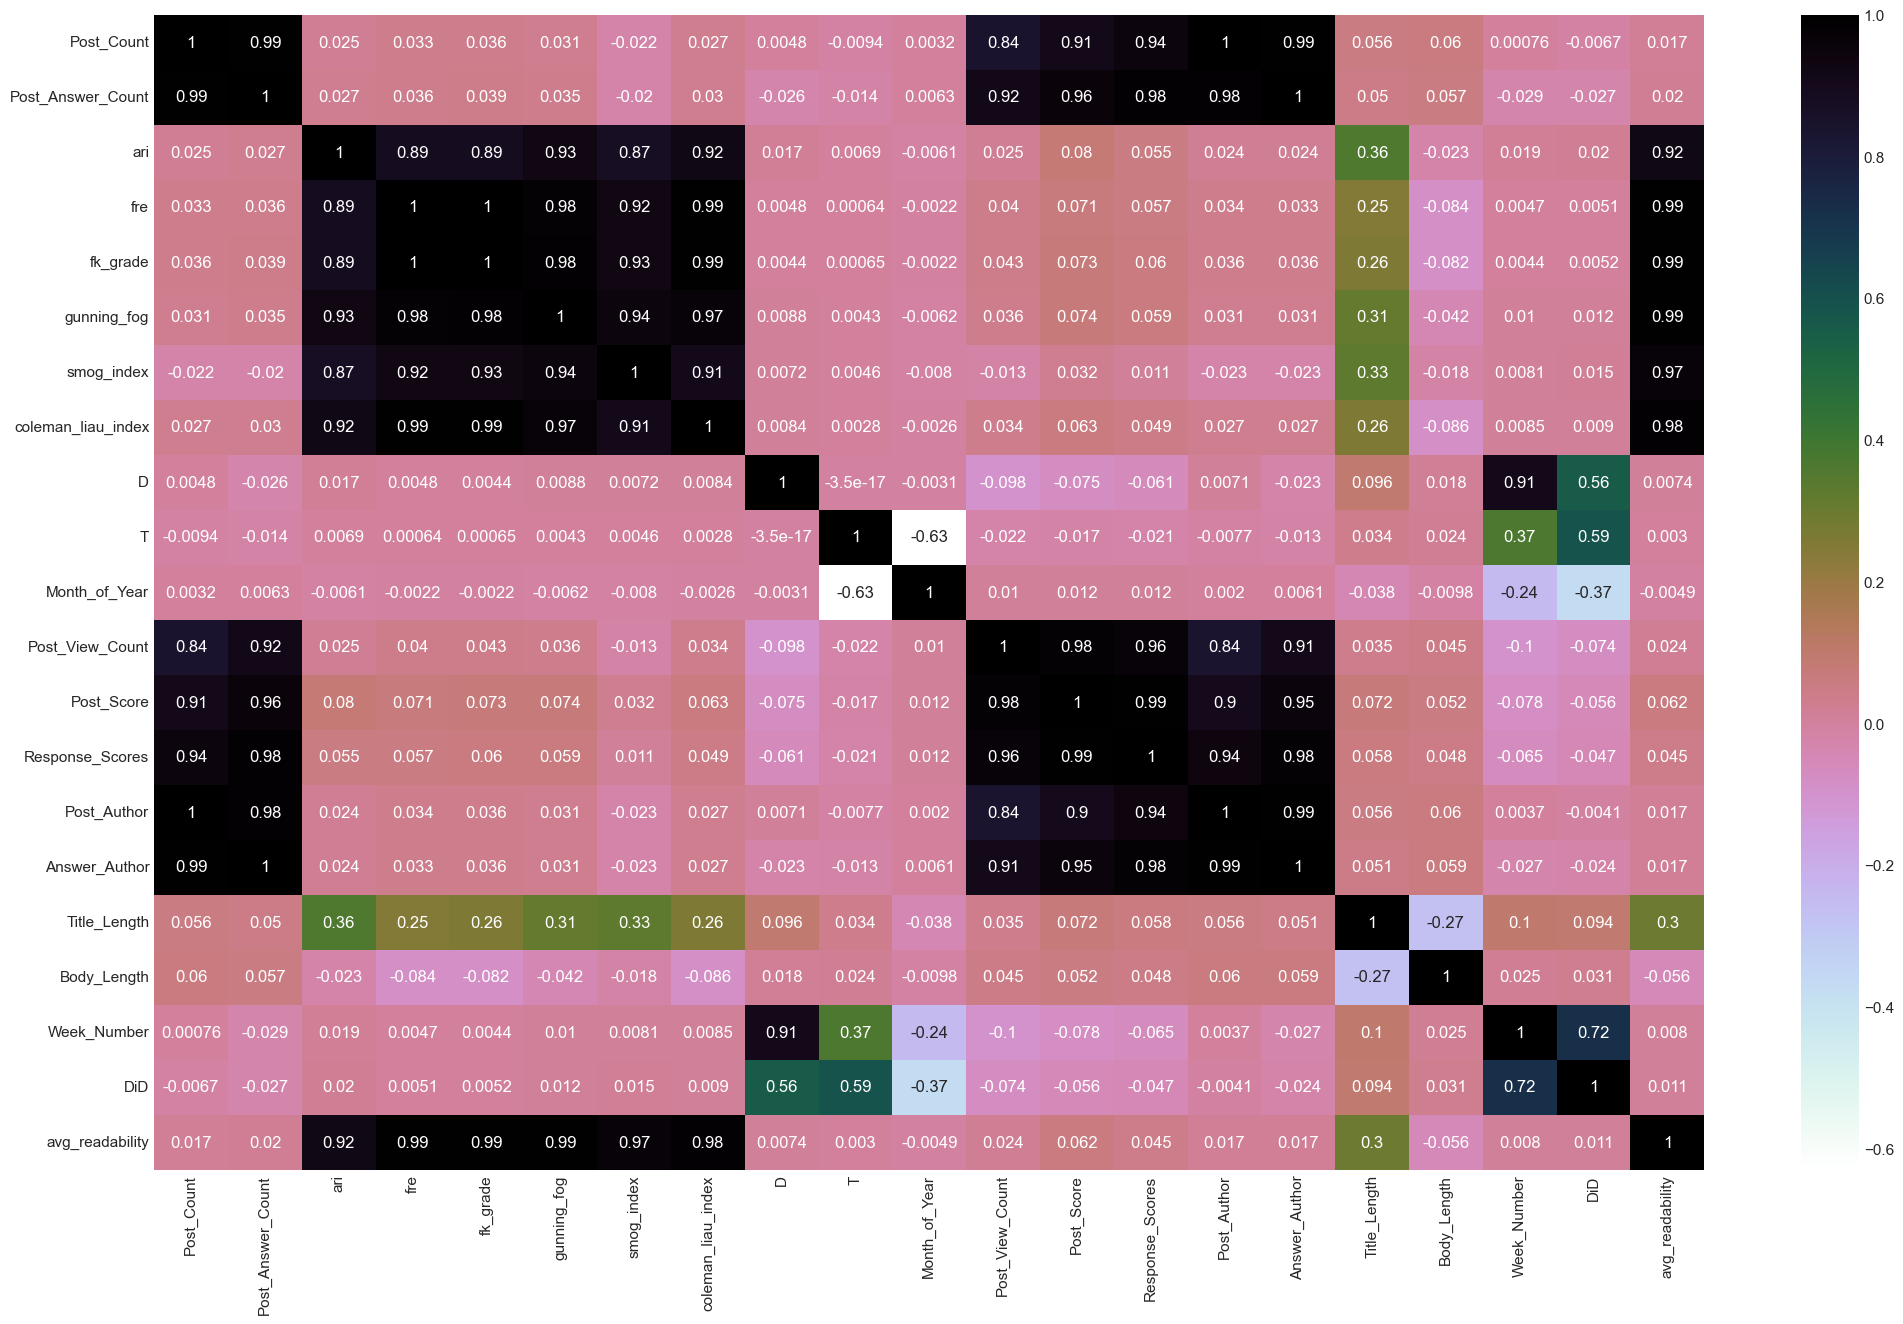

In [34]:
plt.figure(figsize=(25,15)) 
sns.heatmap(data.corr(),annot=True,cmap='cubehelix_r')
plt.show()

### 8.2.1 Post Answer Count

In [37]:
#data drop T
data = data.drop(['T'], axis=1)

In [72]:
from linearmodels.panel import PanelOLS

# Regression - null model, no FX - add intercept
FE_PC_naive = PanelOLS(data.Post_Count, X)
result_PC_naive = FE_PC_naive.fit(cov_type='clustered')

# Regression - FX for Forum/Tag_combined
FE_PC_FE = PanelOLS(data.Post_Count, data[['DiD', 'D', ]], entity_effects=True)
result_PC_FE = FE_PC_FE.fit(cov_type='clustered', cluster_entity=True)

# Regression - FX for Forum/Tag_combined and FX for Weeks
FE_PC_FE_T = PanelOLS(data.Post_Count, data[['DiD', 'D',]], entity_effects=True, time_effects=True)
result_PC_FE_T = FE_PC_FE_T.fit(cov_type='clustered', cluster_entity=True)

# Regression - null model, no FX + controls
FE_PC_naive_controls = PanelOLS(data.Post_Count, X_Controls)
result_PC_naive_controls = FE_PC_naive_controls.fit(cov_type='clustered')

# Regression - FX for Forum/Tag_combined + controls
FE_PC_FE_controls = PanelOLS(data.Post_Count, data[['DiD', 'D' ,'Body_Length', 'Title_Length']], entity_effects=True)
result_PC_FE_controls = FE_PC_FE_controls.fit(cov_type='clustered', cluster_entity=True)

# Regression - FX for Forum/Tag_combined and FX for Weeks + controls
FE_PC_FE_T_controls = PanelOLS(data.Post_Count, data[['DiD', 'D','Body_Length', 'Title_Length']], entity_effects=True, time_effects=True)
result_PC_FE_T_controls = FE_PC_FE_T_controls.fit(cov_type='clustered', cluster_entity=True)

# Results
print(result_PC_naive)
print(result_PC_FE)
print(result_PC_FE_T)
print(result_PC_naive_controls)
print(result_PC_FE_controls)
print(result_PC_FE_T_controls)


                          PanelOLS Estimation Summary                           
Dep. Variable:             Post_Count   R-squared:                        0.0002
Estimator:                   PanelOLS   R-squared (Between):           -2.22e-16
No. Observations:                2940   R-squared (Within):               0.0204
Date:                Mon, May 22 2023   R-squared (Overall):              0.0002
Time:                        13:42:56   Log-likelihood                -2.903e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      0.2217
Entities:                          35   P-value                           0.8012
Avg Obs:                       84.000   Distribution:                  F(2,2937)
Min Obs:                       84.000                                           
Max Obs:                       84.000   F-statistic (robust):             0.2005
                            

In [76]:
# #Estimation does not work with T! (absorbed time effects due to multicollinearity)

# # Regression - null model, no FX - add intercept
# FE_PC_naive = PanelOLS(data.Post_Count, X)
#               #entity_effects = True,
#               #time_effects=True
#               # )      
# # Result
# result_PC_naive = FE_PC_naive.fit(cov_type = 'clustered',
#               # cluster_entity=True,
#               #cluster_time=True
#              )

# # Regression - FX for Forum/Tag_combined
# FE_PC_FE = PanelOLS(data.Post_Count, data[['DiD', 'D', 'T']],
#               entity_effects = True,
#               #time_effects=True
#               )      
# # Result
# result_PC_FE = FE_PC_FE.fit(cov_type = 'clustered',
#               cluster_entity=True,)
#               #cluster_time=True))


# # Regression - FX for Forum/Tag_combined and FX for Weeks
# FE_PC_FE_T = PanelOLS(data.Post_Count, data[['DiD', 'D', 'T']],
#               entity_effects = True,
#               time_effects=True)
              
# # Result
# result_PC_FE_T = FE_PC_FE_T.fit(cov_type = 'clustered',
#               cluster_entity=True, drop_absorbed=True)
#             #   cluster_time=True
            


# # Regression - null model, no FX + controls
# FE_PC_naive_controls = PanelOLS(data.Post_Count, X_Controls)
#               #entity_effects = True,
#               #time_effects=True
#               # )
              
# # Result
# result_PC_naive_controls = FE_PC_naive_controls.fit(cov_type = 'clustered',
#               # cluster_entity=True,
#               #cluster_time=True
#              )

# # Regression - FX for Forum/Tag_combined + controls
# FE_PC_FE_controls  = PanelOLS(data.Post_Count, data[['DiD', 'D', 'T', 'Post_View_Count', 'Post_Score', 'Response_Scores', 'Body_Length', 'Title_Length']],
#               entity_effects = True,
#               #time_effects=True
#               )
              
# # Result
# result_PC_FE_controls = FE_PC_FE_controls.fit(cov_type = 'clustered',
#               cluster_entity=True,
#               #cluster_time=True
#              )

# # # Regression - FX for Forum/Tag_combined and FX for Weeks + contorls
# FE_PC_FE_T_controls  = PanelOLS(data.Post_Count, data[['DiD', 'D', 'T', 'Post_View_Count', 'Post_Score', 'Response_Scores', 'Body_Length', 'Title_Length']],
#               entity_effects = True,
#               time_effects=True
#               )
              
# # Result
# result_PC_FE_T_controls = FE_PC_FE_T_controls.fit(cov_type = 'clustered',
#               cluster_entity=True,
#             #   cluster_time=True
#              )


# #Results
# print(result_PC_naive)
# print(result_PC_FE)
# print(result_PC_FE_T)
# print(result_PC_naive_controls)
# print(result_PC_FE_controls)
# print(result_PC_FE_T_controls)

In [43]:
# Define a function to convert the PanelOLS model summary into a DataFrame
def get_dataframe(model_result):
    coef = model_result.params
    std_err = model_result.std_errors
    t_values = model_result.tstats
    p_values = model_result.pvalues
    conf_int = model_result.conf_int()
    df = pd.DataFrame({'coef': coef, 'std err': std_err, 't': t_values, 'P>|t|': p_values, 'lower CI': conf_int.iloc[:,0], 'upper CI': conf_int.iloc[:,1]})
    return df

# Convert PanelOLS results to pandas DataFrame
df1 = get_dataframe(result_PC_naive)
df2 = get_dataframe(result_PC_FE)
df3 = get_dataframe(result_PC_FE_T)
df4 = get_dataframe(result_PC_naive_controls)
df5 = get_dataframe(result_PC_FE_controls)
df6 = get_dataframe(result_PC_FE_T_controls)

# Concatenate the DataFrames
summary_df = pd.concat([df1, df2, df3, df4, df5, df6], axis=1, keys=['No FX', 'Forum/Tag FX', 'Forum/Tag & Week FX', 'No FX + Controls', 'Forum/Tag FX + Controls', 'Forum/Tag & Week FX + Controls'])

print(summary_df)



                      No FX                                                  \
                       coef     std err         t         P>|t|    lower CI   
const            980.069388  119.782863  8.182050  4.440892e-16  745.202500   
DiD             -150.596234  249.492464 -0.603610  5.461493e-01 -639.794080   
D                116.868275  221.408825  0.527839  5.976508e-01 -317.263958   
Post_View_Count         NaN         NaN       NaN           NaN         NaN   
Post_Score              NaN         NaN       NaN           NaN         NaN   
Response_Scores         NaN         NaN       NaN           NaN         NaN   
Body_Length             NaN         NaN       NaN           NaN         NaN   
Title_Length            NaN         NaN       NaN           NaN         NaN   

                             Forum/Tag FX                                  \
                    upper CI         coef     std err         t     P>|t|   
const            1214.936276          NaN         NaN  

Does it make sense to involve Poisson model? Don't think so

In [45]:
import statsmodels.api as sm

# Regression - null model, no FX
Poisson_model_naive = sm.GLM(data.Post_Count, sm.add_constant(data[['DiD', 'D', 'Body_Length', 'Title_Length']]), 
                             family=sm.families.Poisson())
result_Poisson_PC_naive = Poisson_model_naive.fit(cov_type='HC0')

print(result_Poisson_PC_naive.summary())




                 Generalized Linear Model Regression Results                  
Dep. Variable:             Post_Count   No. Observations:                 2940
Model:                            GLM   Df Residuals:                     2935
Model Family:                 Poisson   Df Model:                            4
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -6.9589e+06
Date:                Mon, 22 May 2023   Deviance:                   1.3897e+07
Time:                        13:36:28   Pearson chi2:                 5.52e+07
No. Iterations:                    10   Pseudo R-squ. (CS):              1.000
Covariance Type:                  HC0                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            2.4344      0.305      7.981   

VIF Values

In [48]:
# # Regression - FX for Forum/Tag_combined and FX for Weeks + contorls
FE_PC_FE_T_controls  = PanelOLS(data.Post_Count, data[['DiD', 'D', 'Body_Length', 'Title_Length']],
              entity_effects = True,
              time_effects=True
              )
              
# Result
result_PC_FE_T_controls = FE_PC_FE_T_controls.fit(cov_type = 'clustered',
              cluster_entity=True,
            #   cluster_time=True
             )


print(result_PC_FE_T_controls)

                          PanelOLS Estimation Summary                           
Dep. Variable:             Post_Count   R-squared:                        0.0096
Estimator:                   PanelOLS   R-squared (Between):             -0.0078
No. Observations:                2940   R-squared (Within):               0.0204
Date:                Mon, May 22 2023   R-squared (Overall):             -0.0076
Time:                        13:37:52   Log-likelihood                -2.177e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      6.9147
Entities:                          35   P-value                           0.0000
Avg Obs:                       84.000   Distribution:                  F(4,2860)
Min Obs:                       84.000                                           
Max Obs:                       84.000   F-statistic (robust):             0.9300
                            

In [47]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from statsmodels.stats.diagnostic import het_breuschpagan

# Subset the DataFrame to only include predictor variables
df_predictors = data[['DiD', 'D', 'Post_View_Count', 'Post_Score', 'Response_Scores', 'Body_Length', 'Title_Length']]

# Add a constant term to your DataFrame. This is necessary for calculating VIF
df_predictors = add_constant(df_predictors)

# Calculate the VIF for each predictor variable
vif = pd.DataFrame()
vif["Variable"] = df_predictors.columns
vif["VIF"] = [variance_inflation_factor(df_predictors.values, i) for i in range(df_predictors.shape[1])]

print(vif)


          Variable         VIF
0            const  152.721030
1              DiD    1.462167
2                D    1.480590
3  Post_View_Count   22.166307
4       Post_Score   80.215816
5  Response_Scores   53.589918
6      Body_Length    1.101387
7     Title_Length    1.158203


Breusch-Pagan Test

In [50]:
# # Make sure data DataFrame is sorted in the same way as during model fitting
# data_sorted = data.sort_values(['Forum', 'Week_of_Year'])

# # Calculate residuals
# predicted = result_PC_FE_T_controls.predict()
# residuals = data_sorted['Post_Count'] - predicted.values

# # apply the test
# bp_test = het_breuschpagan(residuals, data_sorted[['DiD', 'D', 'Body_Length', 'Title_Length']])

# # Print the results
# labels = ['LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test p-value']
# print(dict(zip(labels, bp_test)))


### 8.2.2 Post Answer Count

In [51]:
# Import the packages
import pandas as pd
from linearmodels import PanelOLS
import numpy as np



# Regression
FE_PAC_naive = PanelOLS(data.Post_Answer_Count, X,
              #entity_effects = True,
              #time_effects=True
              )
              
# Result
result_PAC_naive = FE_PAC_naive.fit(cov_type = 'clustered',
              #cluster_entity=True,
              #cluster_time=True
             )


# Regression
FE_PAC = PanelOLS(data.Post_Answer_Count, data[['DiD', 'D']],
              entity_effects = True,
              #time_effects=True
              )
              
# Result
result_PAC_FE = FE_PAC.fit(cov_type = 'clustered',
              cluster_entity=True,)
              #cluster_time=True))


# Regression - FX for Forum/Tag_combined and FX for Weeks
FE_PAC_FE_T = PanelOLS(data.Post_Answer_Count, data[['DiD', 'D']],
              entity_effects = True,
              time_effects=True)
              
# Result
result_PAC_FE_T = FE_PAC_FE_T.fit(cov_type = 'clustered',
              cluster_entity=True,
            #   cluster_time=True
            )



# Regression
FE_PAC_naive_controls = PanelOLS(data.Post_Answer_Count, X_Controls,
              #entity_effects = True,
              #time_effects=True
              )
              
# Result
result_PAC_naive_controls = FE_PAC_naive_controls.fit(cov_type = 'clustered',
              #cluster_entity=True,
              #cluster_time=True
             )

# Regression
FE_PAC_FE_controls = PanelOLS(data.Post_Answer_Count, data[['DiD', 'D', 'Body_Length', 'Title_Length']],
              entity_effects = True,
              #time_effects=True
              )
              
# Result
result_PAC_FE_controls = FE_PAC_FE_controls.fit(cov_type = 'clustered',
              cluster_entity=True,
              #cluster_time=True
             )


# # Regression - FX for Forum/Tag_combined and FX for Weeks + contorls
FE_PAC_FE_T_controls  = PanelOLS(data.Post_Answer_Count, data[['DiD', 'D']],
              entity_effects = True,
              time_effects=True
              )
              
# Result
result_PAC_FE_T_controls = FE_PAC_FE_T_controls.fit(cov_type = 'clustered',
              cluster_entity=True,
            #   cluster_time=True
             )

#Results
print(result_PAC_naive)
print(result_PAC_FE)
print(result_PAC_FE_T)
print(result_PAC_naive_controls)
print(result_PAC_FE_controls)
print(result_PAC_FE_T_controls)

                          PanelOLS Estimation Summary                           
Dep. Variable:      Post_Answer_Count   R-squared:                        0.0009
Estimator:                   PanelOLS   R-squared (Between):              0.0000
No. Observations:                2940   R-squared (Within):               0.0311
Date:                Mon, May 22 2023   R-squared (Overall):              0.0009
Time:                        13:39:12   Log-likelihood                -2.888e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      1.2969
Entities:                          35   P-value                           0.2735
Avg Obs:                       84.000   Distribution:                  F(2,2937)
Min Obs:                       84.000                                           
Max Obs:                       84.000   F-statistic (robust):             1.6534
                            

In [52]:
# Define a function to convert the PanelOLS model summary into a DataFrame
def get_dataframe(model_result):
    coef = model_result.params
    std_err = model_result.std_errors
    t_values = model_result.tstats
    p_values = model_result.pvalues
    conf_int = model_result.conf_int()
    df = pd.DataFrame({'coef': coef, 'std err': std_err, 't': t_values, 'P>|t|': p_values, 'lower CI': conf_int.iloc[:,0], 'upper CI': conf_int.iloc[:,1]})
    return df

# Convert PanelOLS results to pandas DataFrame
df1_PAC = get_dataframe(result_PAC_naive)
df2_PAC = get_dataframe(result_PAC_FE)
df3_PAC = get_dataframe(result_PAC_FE_T)
df4_PAC = get_dataframe(result_PAC_naive_controls)
df5_PAC = get_dataframe(result_PAC_FE_controls)
df6_PAC = get_dataframe(result_PAC_FE_T_controls)

# Concatenate the DataFrames
summary_df_PAC = pd.concat([df1_PAC, df2_PAC, df3_PAC, df4_PAC, df5_PAC, df6_PAC], axis=1, keys=['No FX', 'Forum/Tag FX', 'Forum/Tag & Week FX', 'No FX + Controls', 'Forum/Tag FX + Controls', 'Forum/Tag & Week FX + Controls'])

print(summary_df_PAC)

                       No FX                                                  \
                        coef     std err         t         P>|t|    lower CI   
const            1049.520408  130.289157  8.055317  1.110223e-15  794.053073   
DiD              -187.816364  200.539897 -0.936554  3.490652e-01 -581.029384   
D                -140.955473  203.052390 -0.694183  4.876225e-01 -539.094921   
Post_View_Count          NaN         NaN       NaN           NaN         NaN   
Post_Score               NaN         NaN       NaN           NaN         NaN   
Response_Scores          NaN         NaN       NaN           NaN         NaN   
Body_Length              NaN         NaN       NaN           NaN         NaN   
Title_Length             NaN         NaN       NaN           NaN         NaN   

                             Forum/Tag FX                                  \
                    upper CI         coef     std err         t     P>|t|   
const            1304.987743          NaN    

In [53]:
import statsmodels.api as sm

# Regression - null model, no FX
Poisson_model_naive_PAC = sm.GLM(data.Post_Answer_Count, sm.add_constant(data[['DiD', 'D', 'Body_Length', 'Title_Length']]), 
                             family=sm.families.Poisson())
result_Poisson_PAC_naive = Poisson_model_naive_PAC.fit(cov_type='HC0')

print(result_Poisson_PAC_naive.summary())




                 Generalized Linear Model Regression Results                  
Dep. Variable:      Post_Answer_Count   No. Observations:                 2940
Model:                            GLM   Df Residuals:                     2935
Model Family:                 Poisson   Df Model:                            4
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -6.5886e+06
Date:                Mon, 22 May 2023   Deviance:                   1.3157e+07
Time:                        13:39:36   Pearson chi2:                 5.30e+07
No. Iterations:                     9   Pseudo R-squ. (CS):              1.000
Covariance Type:                  HC0                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            2.6047      0.288      9.053   

In [54]:
# # Regression - FX for Forum/Tag_combined and FX for Weeks + contorls
FE_PAC_FE_T_controls  = PanelOLS(data.Post_Answer_Count, data[['DiD', 'D']],
              entity_effects = True,
              time_effects=True
              )
              
# Result
result_PAC_FE_T_controls = FE_PAC_FE_T_controls.fit(cov_type = 'clustered',
              cluster_entity=True,
            #   cluster_time=True
             )

#Results
print(result_PAC_FE_T_controls)

                          PanelOLS Estimation Summary                           
Dep. Variable:      Post_Answer_Count   R-squared:                        0.0255
Estimator:                   PanelOLS   R-squared (Between):             -0.0112
No. Observations:                2940   R-squared (Within):               0.0303
Date:                Mon, May 22 2023   R-squared (Overall):             -0.0101
Time:                        13:39:41   Log-likelihood                 -2.36e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      37.388
Entities:                          35   P-value                           0.0000
Avg Obs:                       84.000   Distribution:                  F(2,2862)
Min Obs:                       84.000                                           
Max Obs:                       84.000   F-statistic (robust):             6.8915
                            

### 8.2.3 Readability metrics

In [55]:
# Import the packages
import pandas as pd
from linearmodels import PanelOLS
import numpy as np



# Regression
FE_READ_naive = PanelOLS(data.avg_readability, X,
              #entity_effects = True,
              #time_effects=True
              )
              
# Result
result_READ_naive = FE_READ_naive.fit(cov_type = 'clustered',
              #cluster_entity=True,
              #cluster_time=True
             )


# Regression
FE_READ = PanelOLS(data.avg_readability, data[['DiD', 'D']],
              entity_effects = True,
              #time_effects=True
              )
              
# Result
result_READ_FE = FE_READ.fit(cov_type = 'clustered',
              cluster_entity=True,)
              #cluster_time=True))


# Regression - FX for Forum/Tag_combined and FX for Weeks
FE_READ_FE_T = PanelOLS(data.avg_readability, data[['DiD', 'D']],
              entity_effects = True,
              time_effects=True)
              
# Result
result_READ_FE_T = FE_READ_FE_T.fit(cov_type = 'clustered',
              cluster_entity=True,
            #   cluster_time=True
            )



# Regression
FE_READ_naive_controls = PanelOLS(data.avg_readability, X_Controls,
              #entity_effects = True,
              #time_effects=True
              )
              
# Result
result_READ_naive_controls = FE_READ_naive_controls.fit(cov_type = 'clustered',
              #cluster_entity=True,
              #cluster_time=True
             )

# Regression
FE_READ_FE_controls = PanelOLS(data.avg_readability, data[['DiD', 'D', 'Body_Length', 'Title_Length']],
              entity_effects = True,
              #time_effects=True
              )
              
# Result
result_READ_FE_controls = FE_READ_FE_controls.fit(cov_type = 'clustered',
              cluster_entity=True,
              #cluster_time=True
             )


# # Regression - FX for Forum/Tag_combined and FX for Weeks + contorls
FE_READ_FE_T_controls  = PanelOLS(data.avg_readability, data[['DiD', 'D']],
              entity_effects = True,
              time_effects=True
              )
              
# Result
result_READ_FE_T_controls = FE_READ_FE_T_controls.fit(cov_type = 'clustered',
              cluster_entity=True,
            #   cluster_time=True
             )

#Results
print(result_READ_naive)
print(result_READ_FE)
print(result_READ_FE_T)
print(result_READ_naive_controls)
print(result_READ_FE_controls)
print(result_READ_FE_T_controls)


                          PanelOLS Estimation Summary                           
Dep. Variable:        avg_readability   R-squared:                        0.0001
Estimator:                   PanelOLS   R-squared (Between):              0.0000
No. Observations:                2940   R-squared (Within):               0.0099
Date:                Mon, May 22 2023   R-squared (Overall):              0.0001
Time:                        13:40:08   Log-likelihood                    1911.3
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      0.1675
Entities:                          35   P-value                           0.8458
Avg Obs:                       84.000   Distribution:                  F(2,2937)
Min Obs:                       84.000                                           
Max Obs:                       84.000   F-statistic (robust):             0.1642
                            

In [56]:
# Define a function to convert the PanelOLS model summary into a DataFrame
def get_dataframe(model_result):
    coef = model_result.params
    std_err = model_result.std_errors
    t_values = model_result.tstats
    p_values = model_result.pvalues
    conf_int = model_result.conf_int()
    df = pd.DataFrame({'coef': coef, 'std err': std_err, 't': t_values, 'P>|t|': p_values, 'lower CI': conf_int.iloc[:,0], 'upper CI': conf_int.iloc[:,1]})
    return df

# Convert PanelOLS results to pandas DataFrame
df1_READ = get_dataframe(result_READ_naive)
df2_READ = get_dataframe(result_READ_FE)
df3_READ = get_dataframe(result_READ_FE_T)
df4_READ = get_dataframe(result_READ_naive_controls)
df5_READ = get_dataframe(result_READ_FE_controls)
df6_READ = get_dataframe(result_READ_FE_T_controls)

# Concatenate the DataFrames
summary_df_READ = pd.concat([df1_READ, df2_READ, df3_READ, df4_READ, df5_READ, df6_READ], axis=1, keys=['No FX', 'Forum/Tag FX', 'Forum/Tag & Week FX', 'No FX + Controls', 'Forum/Tag FX + Controls', 'Forum/Tag & Week FX + Controls'])

print(summary_df_READ)


                    No FX                                                      \
                     coef   std err           t     P>|t|  lower CI  upper CI   
const            0.401008  0.003281  122.207938  0.000000  0.394574  0.407442   
DiD              0.002749  0.006635    0.414296  0.678688 -0.010261  0.015758   
D                0.000564  0.005594    0.100789  0.919725 -0.010405  0.011533   
Post_View_Count       NaN       NaN         NaN       NaN       NaN       NaN   
Post_Score            NaN       NaN         NaN       NaN       NaN       NaN   
Response_Scores       NaN       NaN         NaN       NaN       NaN       NaN   
Body_Length           NaN       NaN         NaN       NaN       NaN       NaN   
Title_Length          NaN       NaN         NaN       NaN       NaN       NaN   

                Forum/Tag FX                                ...  \
                        coef   std err         t     P>|t|  ...   
const                    NaN       NaN       NaN       

In [58]:
import statsmodels.api as sm

# Regression - null model, no FX
Poisson_model_naive_READ = sm.GLM(data.avg_readability, sm.add_constant(data[['DiD', 'D', 'Body_Length', 'Title_Length']]), 
                             family=sm.families.Poisson())
result_Poisson_READ_naive = Poisson_model_naive_READ.fit(cov_type='HC0')

print(result_Poisson_READ_naive.summary())




                 Generalized Linear Model Regression Results                  
Dep. Variable:        avg_readability   No. Observations:                 2940
Model:                            GLM   Df Residuals:                     2935
Model Family:                 Poisson   Df Model:                            4
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1928.7
Date:                Mon, 22 May 2023   Deviance:                       198.17
Time:                        13:40:29   Pearson chi2:                     112.
No. Iterations:                     4   Pseudo R-squ. (CS):           0.003500
Covariance Type:                  HC0                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -1.9548      0.063    -30.961   

### 8.2.4 Content Novelty

Drop rows with no values of either cos_sim_D0 or cos_sim_D1. Then merge the values into one column and calculate DiD.

In [59]:
final_result_df_tfidf = pd.read_csv('Master Thesis Data\\final_result_df_tfidf.csv')
final_result_df_lsi = pd.read_csv('Master Thesis Data\\final_result_df_lsi.csv')
final_result_df_doc2vec = pd.read_csv('Master Thesis Data\\final_result_df_doc2vec.csv')

In [60]:
#Drop rows of this data frames without cos_sim_D0 or cos_sim_D1 values
final_result_df_tfidf = final_result_df_tfidf.dropna(subset=['cos_sim_D0', 'cos_sim_D1'], how='all')
final_result_df_lsi = final_result_df_lsi.dropna(subset=['cos_sim_D0_lsi', 'cos_sim_D1_lsi'], how='all')
final_result_df_doc2vec = final_result_df_doc2vec.dropna(subset=['cos_sim_D0_doc2vec', 'cos_sim_D1_doc2vec'], how='all')


In [61]:
print(final_result_df_tfidf['cos_sim_D0'].isna().sum())
print(final_result_df_tfidf['cos_sim_D1'].isna().sum())
print(final_result_df_lsi['cos_sim_D0_lsi'].isna().sum())
print(final_result_df_lsi['cos_sim_D1_lsi'].isna().sum())
print(final_result_df_doc2vec['cos_sim_D0_doc2vec'].isna().sum())
print(final_result_df_doc2vec['cos_sim_D1_doc2vec'].isna().sum())

1300
1300
1300
1300
1300
1300


In [62]:
final_result_df_tfidf['cos_sim'] = final_result_df_tfidf['cos_sim_D0'].fillna(final_result_df_tfidf['cos_sim_D1'])
final_result_df_lsi['cos_sim'] = final_result_df_lsi['cos_sim_D0_lsi'].fillna(final_result_df_lsi['cos_sim_D1_lsi'])
final_result_df_doc2vec['cos_sim'] = final_result_df_doc2vec['cos_sim_D0_doc2vec'].fillna(final_result_df_doc2vec['cos_sim_D1_doc2vec'])

In [63]:
#Chech NA count in final_result_df_tfidf['cos_sim']
print(final_result_df_tfidf['cos_sim'].isna().sum())
print(final_result_df_lsi['cos_sim'].isna().sum())
print(final_result_df_doc2vec['cos_sim'].isna().sum())

0
0
0


In [64]:
#Drop 'cos_sim_D0' and 'cos_sim_D1' columns
final_result_df_tfidf = final_result_df_tfidf.drop(['cos_sim_D0', 'cos_sim_D1'], axis=1)
final_result_df_lsi = final_result_df_lsi.drop(['cos_sim_D0_lsi', 'cos_sim_D1_lsi'], axis=1)
final_result_df_doc2vec = final_result_df_doc2vec.drop(['cos_sim_D0_doc2vec', 'cos_sim_D1_doc2vec'], axis=1)

#### Simple Did regressions

In [65]:
#Create interaction term
final_result_df_tfidf['DiD'] = final_result_df_tfidf['D'] * final_result_df_tfidf['T']
final_result_df_lsi['DiD'] = final_result_df_lsi['D'] * final_result_df_lsi['T']
final_result_df_doc2vec['DiD'] = final_result_df_doc2vec['D'] * final_result_df_doc2vec['T']

In [66]:
final_result_df_tfidf

,Post_Creation_Date,Post_View_Count,Post_Title,Post_Score,Post_Answer_Count,Response_Scores,Post_Author,Answer_Author,Forum,Week_of_Year,...,T,Title_Length,Body_Length,Body,count1,count2,count3,count4,cos_sim,DiD
95,2022-04-20 11:46:51,194,Can I define a method of interface type inside...,0,1,1,9090128,0,Stack Overflow,16,...,1,54,299,<pre><code>abstract class someClass\n{\n pu...,95.0,110.0,121.0,121.0,0.053782,0
96,2022-03-16 19:57:08,278,Sort and filter with varying key .net,1,2,2,0,9665021,Stack Overflow,11,...,1,37,680,<p>I have a table in the frontend with multipl...,95.0,110.0,121.0,121.0,0.034316,0
97,2022-01-31 16:08:21,330,Packing the Project didn't create nupkg file (...,0,2,3,14382247,0,Stack Overflow,5,...,1,65,1659,"<p>I followed this guide: <a href=""https://lea...",95.0,110.0,121.0,121.0,0.047094,0
98,2022-01-19 08:38:26,176,C# + .NET : Find the path of an app like chrom...,0,1,1,17014796,0,Stack Overflow,3,...,1,96,577,<p>the best that i have found about my problem...,95.0,110.0,121.0,121.0,0.076700,0
99,2021-12-17 12:10:38,450,AzureKeyVaultConfigurationProvider Cancellatio...,1,1,1,169674,2501279,Stack Overflow,50,...,1,76,1924,<p>I'm currently using <code>IConfigurationBui...,95.0,110.0,121.0,121.0,0.062409,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11459,2023-03-26 13:02:15,60,SQL min and max function not displaying proper...,-2,2,1,21494163,4286884,Stack Overflow,12,...,1,54,594,<p>I am having a problem with using the MIN an...,91.0,69.0,71.0,61.0,0.072648,1
11460,2023-03-24 20:58:21,56,Select values with Condition,0,4,1,838893,0,Stack Overflow,12,...,1,28,1699,"<p>I have a table with this sample data, where...",91.0,69.0,71.0,61.0,0.048503,1
11461,2023-01-10 07:26:38,76,SQL smart search possible?,0,1,0,20945834,0,Stack Overflow,2,...,1,26,2949,<p>I am trying to pull a list from a large rep...,91.0,69.0,71.0,61.0,0.063104,1
11462,2023-03-05 15:03:37,56,SQL SERVER FIND ROWS that dont have values in ...,0,3,5,17128590,18562668,Stack Overflow,9,...,1,59,2448,<p>i have 3 tables with one to many relation\n...,91.0,69.0,71.0,61.0,0.017567,1


In [67]:
final_result_df_tfidf.reset_index(drop=True, inplace=True)
final_result_df_lsi.reset_index(drop=True, inplace=True)
final_result_df_doc2vec.reset_index(drop=True, inplace=True)

In [70]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

model_tfidf = ols('cos_sim ~ D + T + DiD', data=final_result_df_tfidf).fit()
model_lsi = ols('cos_sim ~ D + T + DiD', data=final_result_df_lsi).fit()
model_doc2vec = ols('cos_sim ~ D + T + DiD', data=final_result_df_doc2vec).fit()

print(model_tfidf.summary())
print(model_lsi.summary())
print(model_doc2vec.summary())

                            OLS Regression Results                            
Dep. Variable:                cos_sim   R-squared:                      -0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                  -0.07935
Date:                Mon, 22 May 2023   Prob (F-statistic):               1.00
Time:                        13:41:42   Log-Likelihood:                 6491.5
No. Observations:                2600   AIC:                        -1.298e+04
Df Residuals:                    2597   BIC:                        -1.296e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   6.859e+09   1.98e+10      0.347      0.7

In [383]:
# from linearmodels.panel import PanelOLS

# # Convert the DataFrame to a panel data format
# final_result_panel_tfidf = final_result_df_tfidf.copy().set_index(['tag23FE', 'T'])
# final_result_panel_lsi = final_result_df_lsi.copy().set_index(['tag23FE', 'T'])
# final_result_panel_doc2vec = final_result_df_doc2vec.copy().set_index(['tag23FE', 'T'])

# # Define the model formula
# formula = 'cos_sim ~ D + T + DiD'

# # Fit the models
# model_tfidf = PanelOLS.from_formula(formula, final_result_panel_tfidf).fit()
# model_lsi = PanelOLS.from_formula(formula, final_result_panel_lsi).fit()
# model_doc2vec = PanelOLS.from_formula(formula, final_result_panel_doc2vec).fit()

# # Print the model summaries
# print(model_tfidf.summary)
# print(model_lsi.summary)
# print(model_doc2vec.summary)


In [384]:
# from linearmodels.iv import IV2SLS

# # Define the model formula
# formula = 'cos_sim ~ 1 + D + T + DiD'

# # Fit the models
# model_tfidf = IV2SLS.from_formula(formula, data=final_result_df_tfidf).fit()
# model_lsi = IV2SLS.from_formula(formula, data=final_result_df_lsi).fit()
# model_doc2vec = IV2SLS.from_formula(formula, data=final_result_df_doc2vec).fit()

# # Print the model summaries
# print(model_tfidf.summary)
# print(model_lsi.summary)
# print(model_doc2vec.summary)


#### Poisson models

In [71]:
# import statsmodels.api as sm

# # Regression - null model, no FX
# Poisson_model_naive_tfidf = sm.GLM(final_result_df_tfidf.cos_sim, sm.add_constant(data[['DiD', 'D', 'T']]), 
#                              family=sm.families.Poisson())
# result_Poisson_tfidf_naive = Poisson_model_naive_tfidf.fit(cov_type='HC0')

# print(result_Poisson_tfidf_naive.summary())


